In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Dataset

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.linalg import sqrtm
import numpy as np
import os
from PIL import Image
from sklearn.manifold import TSNE

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
label_string_to_number = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
label_number_to_string = {value: key for key, value in label_string_to_number.items()}

domain_to_number = {'art_painting': 0, 'cartoon':1, 'photo':2, 'sketch':3}

In [4]:
dataset_path = '/kaggle/input/pacs-dataset/kfold'
ds_dict = {}
for domain in os.listdir(dataset_path):
    images_list = []
    domain_path = os.path.join(dataset_path, domain)
    for class_name in os.listdir(domain_path): 
        class_path = os.path.join(domain_path, class_name)
        num_images = len(os.listdir(class_path)) 
        print(f"Domain: {domain:<15}  Class: {class_name:<10}\t Number of images: {num_images:<5}")
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            images_list.append((image_path, label_string_to_number[class_name], domain_to_number[domain]))
    ds_dict[domain] = images_list

Domain: cartoon          Class: horse     	 Number of images: 324  
Domain: cartoon          Class: dog       	 Number of images: 389  
Domain: cartoon          Class: house     	 Number of images: 288  
Domain: cartoon          Class: guitar    	 Number of images: 135  
Domain: cartoon          Class: elephant  	 Number of images: 457  
Domain: cartoon          Class: giraffe   	 Number of images: 346  
Domain: cartoon          Class: person    	 Number of images: 405  
Domain: sketch           Class: horse     	 Number of images: 816  
Domain: sketch           Class: dog       	 Number of images: 772  
Domain: sketch           Class: house     	 Number of images: 80   
Domain: sketch           Class: guitar    	 Number of images: 608  
Domain: sketch           Class: elephant  	 Number of images: 740  
Domain: sketch           Class: giraffe   	 Number of images: 753  
Domain: sketch           Class: person    	 Number of images: 160  
Domain: art_painting     Class: horse     	 Numb

In [149]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
class DomainDataset(Dataset):
    def __init__(self, domain_list, transform=None):
        self.transform = transform
        self.domain_list = domain_list
    
    def __len__(self):
        return len(self.domain_list)
    
    def __getitem__(self, index):
        img_path = self.domain_list[index][0]
        label = self.domain_list[index][1]
        domain = self.domain_list[index][2] 
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label, domain

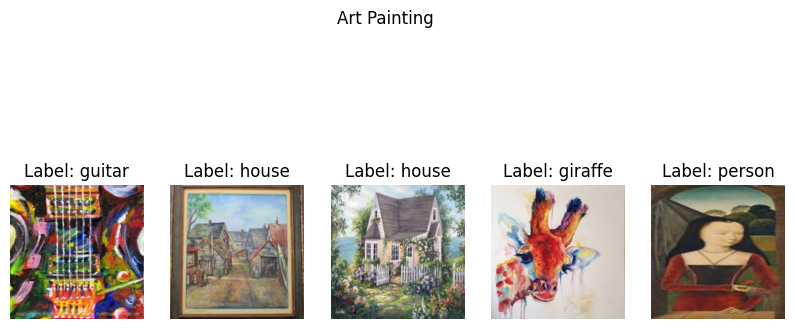

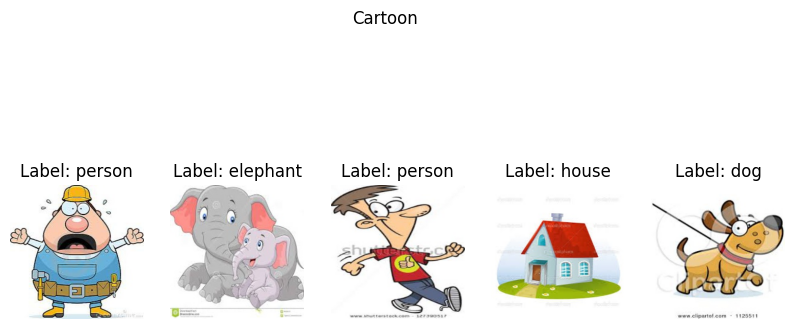

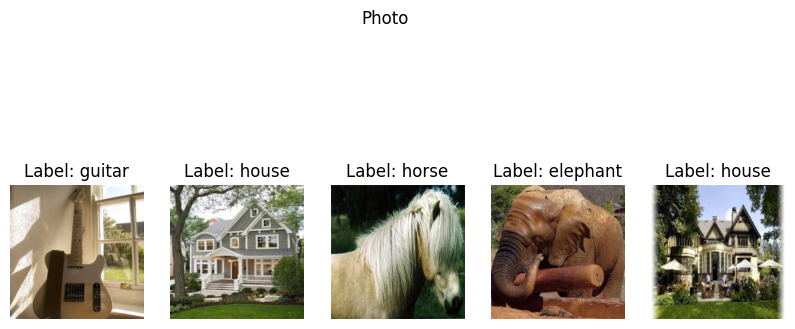

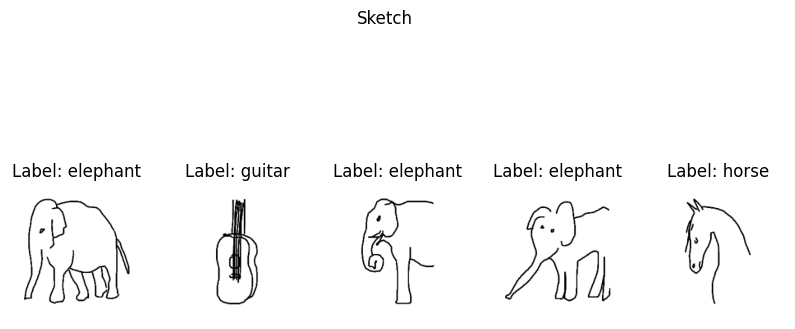

In [134]:
art_painting_dataset = DomainDataset(ds_dict['art_painting'], transform=transform)
cartoon_dataset = DomainDataset(ds_dict['cartoon'], transform=transform)
photo_dataset = DomainDataset(ds_dict['photo'], transform=transform)
sketch_dataset = DomainDataset(ds_dict['sketch'], transform=transform)

batch_size = 32
art_painting_loader = DataLoader(art_painting_dataset, batch_size=batch_size, shuffle=True)
cartoon_loader = DataLoader(cartoon_dataset, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)
sketch_loader = DataLoader(sketch_dataset, batch_size=batch_size, shuffle=True)

def plot_images_from_loader(loader, title):
    plt.figure(figsize=(10, 5))
    for i, (images, labels, _) in enumerate(loader):
        if i == 5: 
            break
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[0].permute(1, 2, 0)) 
        plt.title(f"Label: {label_number_to_string[labels[0].item()]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images_from_loader(art_painting_loader, "Art Painting")
plot_images_from_loader(cartoon_loader, "Cartoon")
plot_images_from_loader(photo_loader, "Photo")
plot_images_from_loader(sketch_loader, "Sketch")


In [135]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
def evaluate_accuracy(loader, model):
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [10]:
def train_model(model, loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train() 
        total_loss = 0

        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()  
            loss.backward() 
            optimizer.step()  
            
            total_loss += loss.item()

        epoch_loss = total_loss / len(loader)
        print(f"epoch {epoch + 1}/{epochs}, loss: {epoch_loss:.4f}")

2.1.a

In [20]:
art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

accuracy on art_painting: 16.16%
accuracy on cartoon: 23.98%
accuracy on photo: 14.01%
accuracy on sketch: 21.58%


2.1.b

In [136]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('training on art_painting')

train_model(resnet, art_painting_loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

training on art_painting
epoch 1/4, loss: 0.8821
epoch 2/4, loss: 0.5240
epoch 3/4, loss: 0.2911
epoch 4/4, loss: 0.2123
accuracy on art_painting: 95.46%
accuracy on cartoon: 65.27%
accuracy on photo: 73.23%
accuracy on sketch: 43.78%


In [137]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('training on cartoon')

train_model(resnet, cartoon_loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

training on cartoon
epoch 1/4, loss: 0.6307
epoch 2/4, loss: 0.2878
epoch 3/4, loss: 0.2236
epoch 4/4, loss: 0.1440
accuracy on art_painting: 45.41%
accuracy on cartoon: 95.69%
accuracy on photo: 59.52%
accuracy on sketch: 50.62%


In [138]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('training on photo')

train_model(resnet, photo_loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

training on photo
epoch 1/4, loss: 0.5619
epoch 2/4, loss: 0.3581
epoch 3/4, loss: 0.2276
epoch 4/4, loss: 0.0957
accuracy on art_painting: 46.48%
accuracy on cartoon: 44.24%
accuracy on photo: 97.84%
accuracy on sketch: 42.00%


In [139]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('training on sketch')

train_model(resnet, sketch_loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

training on sketch
epoch 1/4, loss: 0.5801
epoch 2/4, loss: 0.2867
epoch 3/4, loss: 0.2044
epoch 4/4, loss: 0.1738
accuracy on art_painting: 32.81%
accuracy on cartoon: 48.98%
accuracy on photo: 32.51%
accuracy on sketch: 95.47%


2.1.c

In [140]:
loader = DataLoader(cartoon_dataset + photo_dataset + sketch_dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out art_painting')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out art_painting
epoch 1/4, loss: 0.6566
epoch 2/4, loss: 0.3866
epoch 3/4, loss: 0.2378
epoch 4/4, loss: 0.2028
accuracy on art_painting: 54.05%
accuracy on cartoon: 92.36%
accuracy on photo: 85.45%
accuracy on sketch: 95.09%


In [141]:
loader = DataLoader(art_painting_dataset + photo_dataset + sketch_dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out cartoon')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out cartoon
epoch 1/4, loss: 0.7479
epoch 2/4, loss: 0.4362
epoch 3/4, loss: 0.3041
epoch 4/4, loss: 0.2160
accuracy on art_painting: 90.04%
accuracy on cartoon: 68.09%
accuracy on photo: 94.43%
accuracy on sketch: 95.67%


In [142]:
loader = DataLoader(art_painting_dataset + cartoon_dataset + sketch_dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out photo')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out photo
epoch 1/4, loss: 0.7839
epoch 2/4, loss: 0.4550
epoch 3/4, loss: 0.3211
epoch 4/4, loss: 0.2567
accuracy on art_painting: 86.96%
accuracy on cartoon: 94.67%
accuracy on photo: 67.78%
accuracy on sketch: 89.92%


In [154]:
loader = DataLoader(art_painting_dataset + cartoon_dataset + photo_dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out sketch')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out sketch
epoch 1/4, loss: 1.3697
epoch 2/4, loss: 0.9003
epoch 3/4, loss: 0.6852
epoch 4/4, loss: 0.5169
accuracy on art_painting: 81.93%
accuracy on cartoon: 85.71%
accuracy on photo: 87.54%
accuracy on sketch: 48.54%


2.1.d

In [144]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()  
])

In [145]:
dataset = DomainDataset(ds_dict['cartoon'] + ds_dict['photo'] + ds_dict['sketch'] , transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out art_painting')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out art_painting
epoch 1/4, loss: 0.6862
epoch 2/4, loss: 0.4367
epoch 3/4, loss: 0.3585
epoch 4/4, loss: 0.2825
accuracy on art_painting: 59.67%
accuracy on cartoon: 91.85%
accuracy on photo: 90.36%
accuracy on sketch: 91.55%


In [146]:
dataset = DomainDataset(ds_dict['art_painting'] + ds_dict['photo'] + ds_dict['sketch'] , transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out cartoon')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out cartoon
epoch 1/4, loss: 0.8022
epoch 2/4, loss: 0.4902
epoch 3/4, loss: 0.4086
epoch 4/4, loss: 0.3641
accuracy on art_painting: 82.96%
accuracy on cartoon: 71.97%
accuracy on photo: 90.84%
accuracy on sketch: 90.30%


In [147]:
dataset = DomainDataset(ds_dict['art_painting'] + ds_dict['cartoon'] + ds_dict['sketch'] , transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out photo')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out photo
epoch 1/4, loss: 0.8441
epoch 2/4, loss: 0.5634
epoch 3/4, loss: 0.4438
epoch 4/4, loss: 0.3726
accuracy on art_painting: 84.72%
accuracy on cartoon: 91.38%
accuracy on photo: 75.39%
accuracy on sketch: 88.57%


In [97]:
dataset = DomainDataset(ds_dict['art_painting'] + ds_dict['cartoon'] + ds_dict['photo'] , transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('leaving out sketch')

train_model(resnet, loader, optimizer, criterion, 4)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out sketch
epoch 1/4, loss: 0.7914
epoch 2/4, loss: 0.5348
epoch 3/4, loss: 0.4185
epoch 4/4, loss: 0.3446
accuracy on art_painting: 86.96%
accuracy on cartoon: 91.60%
accuracy on photo: 93.23%
accuracy on sketch: 58.26%


4.1.a

In [20]:
class DomainClassifier(nn.Module):
    def __init__(self, latent_dim, domains):
        super(DomainClassifier, self).__init__()
        self.dc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, domains)
        )
    def forward(self, x):
        return self.dc(x)


class DomainAdverserialModel(nn.Module):
    def __init__(self, resnet, dc):
        super(DomainAdverserialModel, self).__init__()
        self.dc = dc
        self.resnet = resnet
        self.features = nn.Sequential(*list(self.resnet.children())[:-1]) 
        self.label_fc = self.resnet.fc  

                    
    def resnet_forward(self, x):
        features_output = self.features(x)
        features_output =  features_output.view( features_output.size(0), -1)
        fc_output = self.label_fc(features_output)
        return fc_output, features_output

    def dc_forward(self, features_output):
        return self.dc(features_output)

In [74]:
def domain_adversarial_train(da_model, train_loader, test_loader, optimizer_resnet, optimizer_dc, epochs, c):
    ce = nn.CrossEntropyLoss()
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_dc_losses = []

    for epoch in range(epochs):
        da_model.train()
        total_train_loss, total_train_dc_loss = 0, 0
        correct_train, total_train_samples = 0, 0

        for images, labels, domains in train_loader:
            images, labels, domains = images.to(device), labels.to(device), domains.to(device)
            pred_labels, features = da_model.resnet_forward(images)
            loss_label = ce(pred_labels, labels)
            pred_domains = da_model.dc_forward(features)
            loss_domain = ce(pred_domains, domains)
            loss_resnet = loss_label - c * loss_domain

            optimizer_resnet.zero_grad()
            loss_resnet.backward(retain_graph=True)

            optimizer_dc.zero_grad()
            loss_domain.backward()

            optimizer_resnet.step()
            optimizer_dc.step()

            _, predicted_labels = torch.max(pred_labels, 1)
            correct_train += (predicted_labels == labels).sum().item()
            total_train_samples += labels.size(0)
            total_train_loss += loss_resnet.item()
            total_train_dc_loss += loss_domain.item()

        train_losses.append(total_train_loss / len(train_loader))
        train_dc_losses.append(total_train_dc_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train_samples)

        da_model.eval()
        total_test_loss = 0
        correct_test, total_test_samples = 0, 0

        with torch.no_grad():
            for images, labels, _ in test_loader:
                images, labels = images.to(device), labels.to(device)
                pred_labels, _ = da_model.resnet_forward(images)
                loss_label = ce(pred_labels, labels)
                total_test_loss += loss_label.item()

                _, predicted_labels = torch.max(pred_labels, 1)
                correct_test += (predicted_labels == labels).sum().item()
                total_test_samples += labels.size(0)

        test_losses.append(total_test_loss / len(test_loader))
        test_accuracies.append(correct_test / total_test_samples)

        print(f"epoch {epoch + 1}/{epochs}, train loss: {train_losses[-1]:.4f}, train accuracy: {train_accuracies[-1]:.4f}, test loss: {test_losses[-1]:.4f}, test accuracy: {test_accuracies[-1]:.4f}, train DC loss: {train_dc_losses[-1]:.4f}")

    return train_losses, test_losses, train_dc_losses, train_accuracies, test_accuracies


In [42]:
def plot_metrics(epochs, train_losses, test_losses, train_dc_losses, train_accuracies, test_accuracies):
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, test_losses, label="Test Loss")
    plt.plot(epochs_range, train_dc_losses, label="Train DC Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [59]:
def extract_features(da_model, data_loader):
    da_model.eval()
    features_list = []


    with torch.no_grad():
        for images, _, _ in data_loader:
            images = images.to(device)
            
            _, features = da_model.resnet_forward(images)
            features_list.append(features.cpu().numpy())
    
    features_array = np.concatenate(features_list, axis=0)
    return features_array
    

def plot_tsne(train_features, test_features):
    tsne = TSNE(n_components=2, random_state=1)
    combined_features = np.concatenate([train_features, test_features], axis=0)
    labels = ['Train'] * len(train_features) + ['Test'] * len(test_features)

    features_2d = tsne.fit_transform(combined_features)

    plt.figure(figsize=(10, 6))
    for label, marker, color in [('Train', '.', 'blue'), ('Test', '.', 'red')]:
        indices = [i for i, lbl in enumerate(labels) if lbl == label]
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], marker=marker, color=color, alpha=0.5, label=label)
    plt.legend()
    plt.show()


In [127]:
dataset = DomainDataset(ds_dict['art_painting'] + ds_dict['cartoon'] + ds_dict['photo'] , transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)
lr = 0.0001
optimizer_resnet = optim.Adam(resnet.parameters(), lr=lr)

dc = DomainClassifier(resnet.fc.in_features, 4)
dc.to(device)
optimizer_dc = optim.Adam(dc.parameters(), lr=0.001)

da_model = DomainAdverserialModel(resnet, dc)

In [128]:
# extracting features before training
features_train_before = extract_features(da_model, train_loader)
features_test_before = extract_features(da_model, sketch_loader)

In [129]:
print('leaving out sketch')

train_losses, test_losses, train_dc_losses, train_accuracies, test_accuracies = domain_adversarial_train(da_model, train_loader, sketch_loader, optimizer_resnet, optimizer_dc, 4, 0.05)

art_painting_accuracy = evaluate_accuracy(art_painting_loader, resnet)
print(f"accuracy on art_painting: {art_painting_accuracy:.2f}%")

cartoon_accuracy = evaluate_accuracy(cartoon_loader, resnet)
print(f"accuracy on cartoon: {cartoon_accuracy:.2f}%")

photo_accuracy = evaluate_accuracy(photo_loader, resnet)
print(f"accuracy on photo: {photo_accuracy:.2f}%")

sketch_accuracy = evaluate_accuracy(sketch_loader, resnet)
print(f"accuracy on sketch: {sketch_accuracy:.2f}%")

leaving out sketch
epoch 1/4, train loss: 0.4631, train accuracy: 0.8476, test loss: 0.9579, test accuracy: 0.6396, train DC loss: 0.2129
epoch 2/4, train loss: 0.1627, train accuracy: 0.9532, test loss: 0.9093, test accuracy: 0.6681, train DC loss: 0.0916
epoch 3/4, train loss: 0.1018, train accuracy: 0.9698, test loss: 1.1607, test accuracy: 0.5729, train DC loss: 0.0584
epoch 4/4, train loss: 0.0649, train accuracy: 0.9832, test loss: 0.9863, test accuracy: 0.6539, train DC loss: 0.0471
accuracy on art_painting: 99.37%
accuracy on cartoon: 99.74%
accuracy on photo: 99.70%
accuracy on sketch: 65.39%


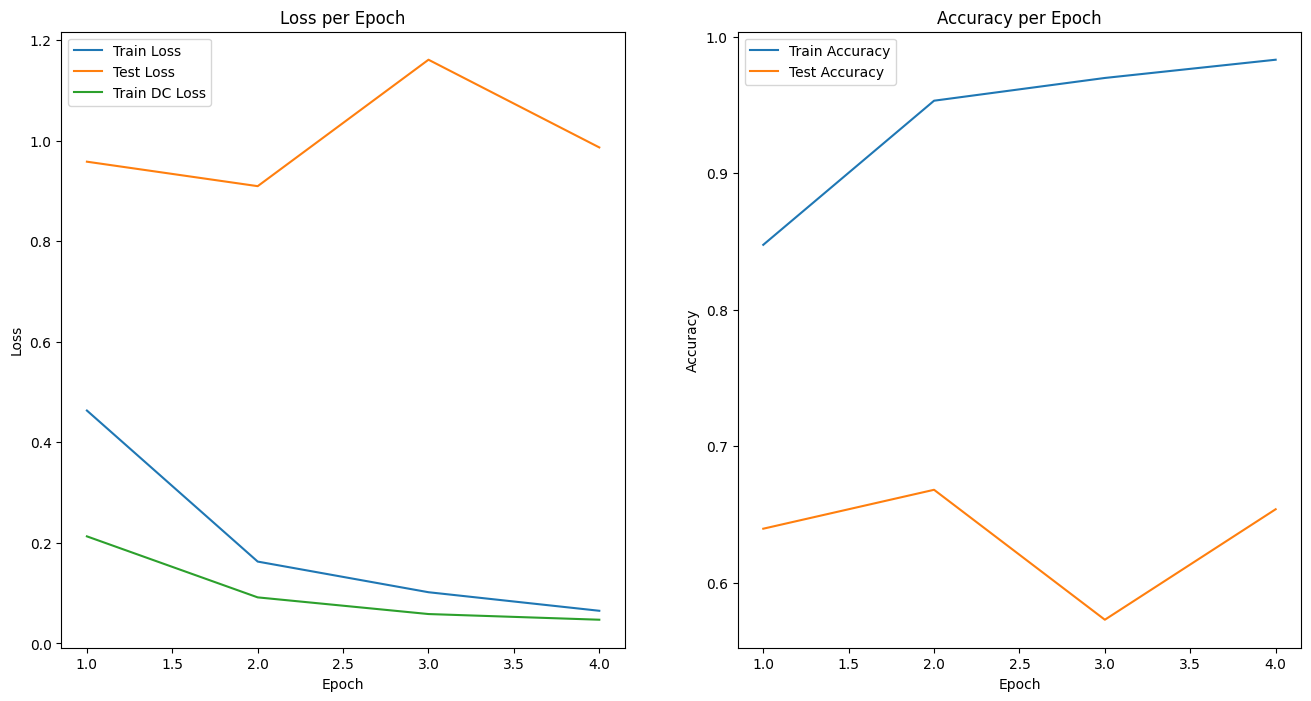

In [131]:
plot_metrics(4, train_losses, test_losses, train_dc_losses, train_accuracies, test_accuracies)

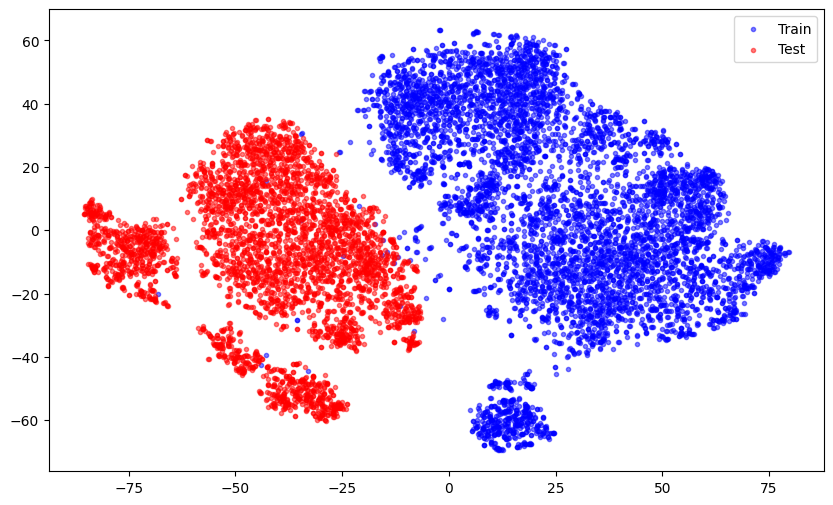

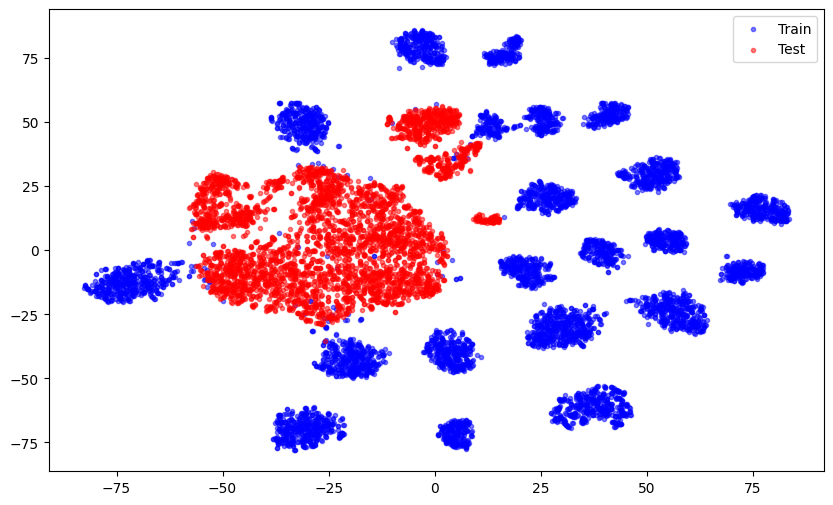

In [132]:
# extracting features after training
features_train_after = extract_features(da_model, train_loader)
features_test_after = extract_features(da_model, sketch_loader)


plot_tsne(features_train_before, features_test_before)
plot_tsne(features_train_after, features_test_after)